In [1]:
import os
import time

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
books = spark.read.load(r"../Dataset/BX-Books.csv",
                     format="csv", sep=";", inferSchema="true", header="true", encoding ='latin1')

In [4]:
win_row_number = Window.orderBy("ISBN")
isbn = books.select(F.row_number().over(win_row_number).alias("book_id"), "ISBN")
isbn.show(3)

+-------+----------+
|book_id|      ISBN|
+-------+----------+
|      1|0000913154|
|      2|0001010565|
|      3|0001046438|
+-------+----------+
only showing top 3 rows



In [5]:
ratings = spark.read.load(r"../Dataset/BX-Book-Ratings.csv",
                     format="csv", sep=";", inferSchema="true", header="true", encoding ='latin1')

In [6]:
ratings = ratings.withColumn("Book-Rating", ratings["Book-Rating"].cast("Float"))
ratings_with_bid = ratings.join(isbn, on=["ISBN"], how="inner")
ratings_with_bid.show(3)

+----------+-------+-----------+-------+
|      ISBN|User-ID|Book-Rating|book_id|
+----------+-------+-----------+-------+
|0002234947|  39608|        0.0|    216|
|0002234947| 219445|        0.0|    216|
|0002234947| 227275|        0.0|    216|
+----------+-------+-----------+-------+
only showing top 3 rows



In [3]:
books.count()

271379

In [5]:
ratings.count()

1149780

In [7]:
grouped_df = ratings_with_bid.where(F.col('Book-Rating') > 0).groupBy('book_id').count().orderBy(F.desc('count'))
grouped_df.show(3)

+-------+-----+
|book_id|count|
+-------+-----+
|  38732|  707|
| 216754|  581|
|  71062|  487|
+-------+-----+
only showing top 3 rows



In [8]:
import numpy as np
count_arr = np.array(grouped_df.select('count').collect()).reshape(1,-1)
count_arr

array([[707, 581, 487, ...,   1,   1,   1]])

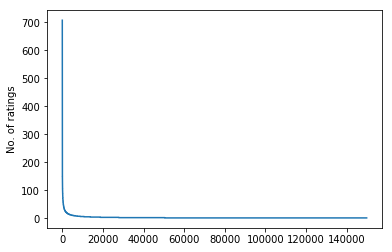

In [9]:
plt.plot(count_arr[0])
plt.ylabel('No. of ratings')
plt.show()

### Observation
From the plot above, it is clear that the $ratings$ matrix is very sparse. So, for the prototype we will use top 100 for the prototype

In [8]:
ratings_with_bid.count()

1031175

In [8]:
sample_df = ratings_with_bid.sample(False, 0.01, seed=11).select(F.column('User-ID').alias('user'), F.column('book_id').alias('item'), F.column('Book-Rating').alias('rating'))
sample_df.show()

+------+-----+------+
|  user| item|rating|
+------+-----+------+
|136205| 3847|   0.0|
|278418| 5422|   0.0|
|170229|26381|   0.0|
| 20115|33238|   0.0|
|250012|35447|   0.0|
|166596|44103|   0.0|
|236913|44103|   0.0|
|123981|44902|   5.0|
|267453|45250|   0.0|
|136213|45395|   0.0|
|110973|50203|   0.0|
|152186|57124|   6.0|
|251263|57562|   0.0|
| 69078|60142|   0.0|
|147978|60142|   0.0|
| 52853|65547|   0.0|
|231518|71211|   8.0|
|128696|78967|   0.0|
|158295|81626|   7.0|
| 87746|82090|   0.0|
+------+-----+------+
only showing top 20 rows



In [10]:
sample_df.count()

10389

In [12]:
sample_df.select('item').distinct().count()

8952

In [13]:
sample_df.select('user').distinct().count()

5278

In [ ]:
sample_df = sample_df

In [9]:
training, test = sample_df.randomSplit([0.8, 0.2], 24)

In [17]:
training.show(100)

+------+------+------+
|  user|  item|rating|
+------+------+------+
| 20115| 33238|   0.0|
| 27947|190910|   6.0|
| 38158|122236|   0.0|
| 52853| 65547|   0.0|
| 69078| 60142|   0.0|
| 81045|166093|   0.0|
| 87746| 82090|   0.0|
| 90662|245291|   0.0|
|109545|263585|   9.0|
|110973| 50203|   0.0|
|123981| 44902|   5.0|
|128696| 78967|   0.0|
|136205|  3847|   0.0|
|136213| 45395|   0.0|
|147978| 60142|   0.0|
|152186| 57124|   6.0|
|156214|176639|  10.0|
|158295| 81626|   7.0|
|158295| 93651|   0.0|
|161234|190910|   4.0|
|163804| 87670|   0.0|
|166596| 44103|   0.0|
|172030|187230|   0.0|
|177458|142264|   0.0|
|185778|109195|   7.0|
|186719|123760|   0.0|
|199772|157334|   7.0|
|202269|217338|   6.0|
|212923| 83084|   0.0|
|215225|260577|   0.0|
|222563|190910|  10.0|
|226965|149828|  10.0|
|229741|132685|   0.0|
|231518| 71211|   8.0|
|231827|109053|   0.0|
|236913| 44103|   0.0|
|244159|256088|   5.0|
|247447|119073|  10.0|
|250012| 35447|   0.0|
|251263| 57562|   0.0|
|267453| 45

In [13]:
als = ALS()

In [14]:
param_grid = ParamGridBuilder().addGrid(als.rank, [9, 10, 11]).addGrid(als.maxIter, [8, 9, 10]).addGrid(als.regParam, [.17, .18, .19]).build()

In [8]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [16]:
# Cross Validation using TrainValidationSplit
tvs = TrainValidationSplit(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator)

In [17]:
model = tvs.fit(training)

In [19]:
best_model = model.bestModel

In [20]:
print(("Rank: {}\nMaximum Iteration: {}\nRegularization: {}").format(best_model.rank, best_model._java_obj.parent().getMaxIter(), best_model._java_obj.parent().getRegParam()))

Rank: 9
Maximum Iteration: 8
Regularization: 0.17


In [32]:
prediciton_on_train = best_model.transform(training)

In [33]:
prediciton_on_train.show()

+------+------+------+----------+
|  user|  item|rating|prediction|
+------+------+------+----------+
| 56856| 18911|   7.0|  6.296803|
|212645| 18911|   0.0|       0.0|
|205080| 19079|   0.0|       0.0|
|123500| 35351|   0.0|       0.0|
| 76626| 38395|   9.0|  8.860713|
|236948| 40574|   8.0|  7.923811|
|132392| 43688|   9.0|  8.882377|
|159847| 43688|   0.0|       0.0|
|166830| 48398|   0.0|       0.0|
|229551| 51123|   0.0|       0.0|
| 40943| 51393|   0.0|       0.0|
|153662| 55283|   9.0|  8.841433|
| 51252| 73305|   0.0|       0.0|
|216386| 78440|   0.0|       0.0|
|249294| 87120|   5.0| 4.8892612|
| 42573| 99621|   0.0|       0.0|
|100088| 99786|   9.0|  8.931327|
|165232|108806|   0.0|       0.0|
|154176|109050|   0.0|       0.0|
| 41138|117500|   0.0|       0.0|
+------+------+------+----------+
only showing top 20 rows



In [25]:
predictions = best_model.transform(test)

In [26]:
predictions.show(20)

+------+------+------+----------+
|  user|  item|rating|prediction|
+------+------+------+----------+
|135703| 43302|   0.0|       NaN|
|239584| 43688|   0.0|-0.9231076|
|110973| 50348|   0.0|       NaN|
|  7346|134607|   0.0|       NaN|
| 63389|145210|   7.0|       NaN|
| 86538|150375|   0.0|       NaN|
|211979|213270|   5.0|       NaN|
|173684|239370|   0.0|       NaN|
|143062|263294|   0.0|       NaN|
| 96771|100570|   0.0|       NaN|
| 29915|164704|   0.0|       NaN|
| 84880|200682|   7.0|       NaN|
| 12828|240162|   0.0|       NaN|
|156150| 18382|   0.0|       0.0|
|161101| 52288|  10.0|       NaN|
|134630| 82432|   9.0|       NaN|
|273110| 82432|   0.0|       0.0|
|238557| 93806|   0.0|       NaN|
|242299|102681|  10.0|       NaN|
|232598|142666|   0.0|       NaN|
+------+------+------+----------+
only showing top 20 rows



In [27]:
predictions.count()

2130

In [28]:
filtered_predicitons = predictions.dropna(thresh=1, subset=['prediction'])

In [30]:
filtered_predicitons.count()

230

In [31]:
filtered_predicitons.show()

+------+------+------+----------+
|  user|  item|rating|prediction|
+------+------+------+----------+
|239584| 43688|   0.0|-0.9231076|
|156150| 18382|   0.0|       0.0|
|273110| 82432|   0.0|       0.0|
| 30261|176542|   0.0|       0.0|
|178667|118651|   0.0|-0.9517669|
| 51883|118651|   0.0| 1.0684421|
| 97160| 82969|   0.0|       0.0|
|113519| 33138|   0.0|       0.0|
|187145|220330|   0.0|  5.528087|
|265115| 78532|   0.0|       0.0|
| 90915| 70901|   0.0|       0.0|
| 87555|131488|   0.0| 2.2886047|
| 36836| 81794|   0.0|       0.0|
|240906| 86649|   8.0| 1.0491456|
|180917| 86649|   0.0|       0.0|
| 11676|222569|   6.0|       0.0|
|153662| 59816|   0.0|       0.0|
|166596| 88037|   0.0|0.91217756|
|160735| 93403|   0.0|       0.0|
|  5582| 96215|  10.0|       0.0|
+------+------+------+----------+
only showing top 20 rows



In [29]:
rmse = evaluator.evaluate(predictions.dropna(thresh=1, subset=['prediction']))

In [30]:
print("RMSE: " + str(rmse))

RMSE: 0.04882928660044964


In [ ]:
import numpy as np
rmse_test_arr = [];
rmse_train_arr = [];

In [46]:
for rnk in np.arange(20, 100, 20):
    best_als_est = ALS(rank=rnk, maxIter=8, regParam=0.17)
    best_als_model = best_als_est.fit(training)
    filtered_prediction = best_als_model.transform(test).where(~F.isnan(F.col('prediction')))
    rmse_test = evaluator.evaluate(filtered_prediction)
    rmse_train = evaluator.evaluate(best_als_model.transform(training))
    rmse_test_arr.append([rnk, rmse_test])
    rmse_train_arr.append([rnk, rmse_train])

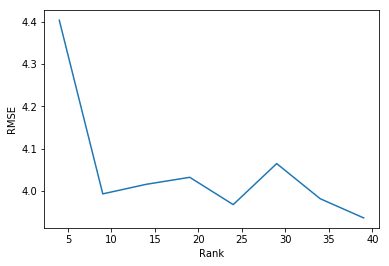

In [43]:
plt.plot(np.array(rmse_test_arr)[:,0], np.array(rmse_test_arr)[:,1], c='r', label='Test')
plt.plot(np.array(rmse_train_arr)[:,0], np.array(rmse_train_arr)[:,1], c='g', label='Train')
plt.xlabel('Rank')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.plot(np.array(p)[:,0], np.array(p)[:,1])
plt.xlabel('Rank')
plt.ylabel('RMSE')
plt.show()

In [56]:
best_als_est = ALS(rank=9, maxIter=8, regParam=0.17)
best_als_model = best_als_est.fit(training)
filtered_prediction = best_als_model.transform(test).where(~F.isnan(F.col('prediction')))
rmse_test = evaluator.evaluate(filtered_prediction)
rmse_train = evaluator.evaluate(best_als_model.transform(training))
rmse_test_arr.append([9, rmse_test])
rmse_train_arr.append([9, rmse_train])

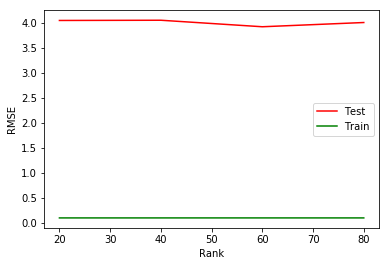

In [47]:
plt.plot(np.array(rmse_test_arr)[:,0], np.array(rmse_test_arr)[:,1], c='r', label='Test')
plt.plot(np.array(rmse_train_arr)[:,0], np.array(rmse_train_arr)[:,1], c='g', label='Train')
plt.xlabel('Rank')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

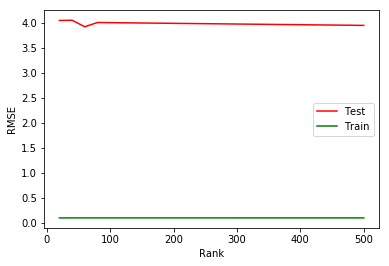

In [53]:
plt.plot(np.array(rmse_test_arr)[:,0], np.array(rmse_test_arr)[:,1], c='r', label='Test')
plt.plot(np.array(rmse_train_arr)[:,0], np.array(rmse_train_arr)[:,1], c='g', label='Train')
plt.xlabel('Rank')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

In [57]:
rmse_test_arr

[[20, 4.0531929665916255],
 [40, 4.057599564866404],
 [60, 3.9274376772964157],
 [80, 4.012151474882954],
 [500, 3.9546797562188902],
 [9, 3.9927479372963877]]

In [58]:
rmse_train_arr

[[20, 0.10478106054081336],
 [40, 0.1048359407150912],
 [60, 0.1048845932117174],
 [80, 0.10483420352917373],
 [500, 0.10501015862647513],
 [9, 0.10477876174648941]]

In [14]:
predictions.transform(test).where(~F.isnan(F.col('prediction'))).show(50)

+------+------+------+----------+
|  user|  item|rating|prediction|
+------+------+------+----------+
|239584| 43688|   0.0|-0.9099755|
|156150| 18382|   0.0|       0.0|
|273110| 82432|   0.0|       0.0|
| 30261|176542|   0.0|       0.0|
|178667|118651|   0.0|-0.9706616|
| 51883|118651|   0.0| 1.0573839|
| 97160| 82969|   0.0|       0.0|
|113519| 33138|   0.0|       0.0|
|187145|220330|   0.0|  5.471162|
|265115| 78532|   0.0|       0.0|
| 90915| 70901|   0.0|       0.0|
| 87555|131488|   0.0| 2.2869062|
| 36836| 81794|   0.0|       0.0|
|240906| 86649|   8.0| 1.0373452|
|180917| 86649|   0.0|       0.0|
| 11676|222569|   6.0|       0.0|
|153662| 59816|   0.0|       0.0|
|166596| 88037|   0.0|0.88773626|
|160735| 93403|   0.0|       0.0|
|  5582| 96215|  10.0|       0.0|
|209756| 98083|   0.0|       0.0|
|183347|104383|   8.0|       0.0|
|229329|198753|   0.0|       0.0|
| 10314| 62047|   0.0|       0.0|
| 36609|246334|   0.0|-1.3148633|
|190925|  3260|   0.0|       0.0|
|  9417| 81395

In [8]:
rmse_test_arr_2 = []

In [9]:
rmse_train_arr_2 = []

In [16]:
%%time
training_2, test_2 = ratings_with_bid.select(F.column('User-ID').alias('user'), F.column('book_id').alias('item'), F.column('Book-Rating').alias('rating')).randomSplit([0.95, 0.05], 24)
for rnk in np.arange(48, 102, 6):
    best_als_est_2 = ALS(rank=rnk, maxIter=8, regParam=0.17)
    best_als_model_2 = best_als_est_2.fit(training_2)
    filtered_prediction_2 = best_als_model_2.transform(test_2).where(~F.isnan(F.col('prediction')))
    rmse_test_2 = evaluator.evaluate(filtered_prediction_2)
    rmse_train_2 = evaluator.evaluate(best_als_model_2.transform(training_2))
    rmse_test_arr_2.append([rnk, rmse_test_2])
    rmse_train_arr_2.append([rnk, rmse_train_2])


CPU times: user 623 ms, sys: 146 ms, total: 769 ms
Wall time: 45min 45s


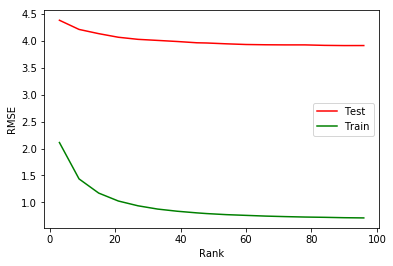

In [17]:
plt.plot(np.array(rmse_test_arr_2)[:,0], np.array(rmse_test_arr_2)[:,1], c='r', label='Test')
plt.plot(np.array(rmse_train_arr_2)[:,0], np.array(rmse_train_arr_2)[:,1], c='g', label='Train')
plt.xlabel('Rank')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

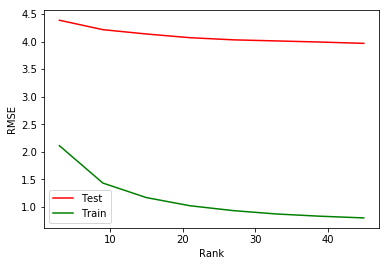

In [14]:
plt.plot(np.array(rmse_test_arr_2)[:,0], np.array(rmse_test_arr_2)[:,1], c='r', label='Test')
plt.plot(np.array(rmse_train_arr_2)[:,0], np.array(rmse_train_arr_2)[:,1], c='g', label='Train')
plt.xlabel('Rank')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

In [15]:
filtered_prediction_2.show()

+------+-----+------+------------+
|  user| item|rating|  prediction|
+------+-----+------+------------+
|111816| 1580|   0.0|         0.0|
|240829| 1580|   0.0|         0.0|
|152249| 1591|   0.0| -0.09379472|
|225087| 3997|   0.0|  0.70980996|
|232522| 4818|   8.0|         0.0|
|110483| 6620|   8.0|    1.213587|
|204864| 7554|   0.0|  0.49222705|
|209536| 9427|   7.0| -0.48650128|
| 89852| 9427|   0.0|   2.9078887|
|142524| 9465|   0.0|-0.051879734|
|167800| 9852|   0.0| -0.43454313|
|232131|11317|   0.0| -0.08727478|
| 67053|13623|   7.0|  -2.3892176|
| 11676|13623|   7.0|   1.8283451|
|171970|18051|   6.0|   4.1777024|
|146348|18051|   8.0|   0.5552469|
|149510|18051|   7.0|   2.4615123|
|223087|18911|   0.0|   1.0165336|
| 87555|19079|   0.0|   3.2599561|
| 10819|20735|   0.0|         0.0|
+------+-----+------+------------+
only showing top 20 rows



In [8]:
%%time
training_3, test_3 = ratings_with_bid.select(F.column('User-ID').alias('user'), F.column('book_id').alias('item'), F.column('Book-Rating').alias('rating')).randomSplit([0.95, 0.05], 24)
best_als_est_3 = ALS(rank=6, maxIter=100, regParam=0.01)
best_als_model_3 = best_als_est_3.fit(training_3)
filtered_prediction_3 = best_als_model_3.transform(test_3).where(~F.isnan(F.col('prediction')))
rmse_test_3 = evaluator.evaluate(filtered_prediction_3)
rmse_train_3 = evaluator.evaluate(best_als_model_3.transform(training_3))


Py4JJavaError: An error occurred while calling o89.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 82.0 failed 1 times, most recent failure: Lost task 2.0 in stage 82.0 (TID 1154, localhost, executor driver): java.lang.StackOverflowError
	at java.io.ObjectInputStream$PeekInputStream.peek(ObjectInputStream.java:2639)
	at java.io.ObjectInputStream$BlockDataInputStream.peek(ObjectInputStream.java:2946)
	at java.io.ObjectInputStream$BlockDataInputStream.peekByte(ObjectInputStream.java:2956)
	at java.io.ObjectInputStream.readClassDesc(ObjectInputStream.java:1736)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2040)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1168)
	at org.apache.spark.ml.recommendation.ALS$.train(ALS.scala:1031)
	at org.apache.spark.ml.recommendation.ALS$$anonfun$fit$1.apply(ALS.scala:676)
	at org.apache.spark.ml.recommendation.ALS$$anonfun$fit$1.apply(ALS.scala:658)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:183)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:183)
	at org.apache.spark.ml.recommendation.ALS.fit(ALS.scala:658)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.StackOverflowError
	at java.io.ObjectInputStream$PeekInputStream.peek(ObjectInputStream.java:2639)
	at java.io.ObjectInputStream$BlockDataInputStream.peek(ObjectInputStream.java:2946)
	at java.io.ObjectInputStream$BlockDataInputStream.peekByte(ObjectInputStream.java:2956)
	at java.io.ObjectInputStream.readClassDesc(ObjectInputStream.java:1736)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2040)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)
	at scala.collection.immutable.List$SerializationProxy.readObject(List.scala:490)
	at sun.reflect.GeneratedMethodAccessor11.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at java.io.ObjectStreamClass.invokeReadObject(ObjectStreamClass.java:1158)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2176)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2285)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2209)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2067)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1571)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:431)


In [11]:
%%time
training_4, test_4 = ratings_with_bid.select(F.column('User-ID').alias('user'), F.column('book_id').alias('item'), F.column('Book-Rating').alias('rating')).randomSplit([0.95, 0.05], 24)
best_als_est_4 = ALS(rank=6, maxIter=20, regParam=0.01)
best_als_model_4 = best_als_est_4.fit(training_4)
filtered_prediction_4 = best_als_model_4.transform(test_4).where(~F.isnan(F.col('prediction')))
rmse_test_4 = evaluator.evaluate(filtered_prediction_4)
rmse_train_4 = evaluator.evaluate(best_als_model_4.transform(training_4))
print(rmse_test_4, rmse_train_4)

5.82481520450291 1.5082879390843076
CPU times: user 49.8 ms, sys: 14.8 ms, total: 64.6 ms
Wall time: 1min 21s
